In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

2024-01-20 11:03:42.819558: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 11:03:42.855594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 11:03:42.855619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 11:03:42.856472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 11:03:42.861871: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-20 11:03:42.862469: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
CLOSE = "Close_ETH"

In [3]:
file_path = '../data/federalfinancegestion/Rennes_DataChallenge2024_Cryptomarkets_dataset.xlsx'
data = pd.read_excel(file_path)

# Remove all string (object type) columns from the dataset
data_numeric = data.select_dtypes(exclude=['object'])

# Finding the column that closely matches "Close_BTC" in the numeric dataset
close_btc_column_numeric = [col for col in data_numeric.columns if "Close_BTC" in col]

close_btc_column_numeric = close_btc_column_numeric[0]
# Calculate the correlation of all columns with Close_BTC in the numeric dataset
correlation_with_close_btc_numeric = data_numeric.corr()[close_btc_column_numeric].sort_values(ascending=False)

# Extract the top 10 most correlated feature names
top_feature = correlation_with_close_btc_numeric.head(10).index.tolist()
include = top_feature

In [4]:
# Load data
dataset_pickle = '../data/federalfinancegestion/dataset.pkl'
df = pd.read_pickle(dataset_pickle)
df.fillna(0, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

start_date_training = pd.to_datetime('2017-08-01')
end_date_training = pd.to_datetime('2022-08-31')
start_date_testing = pd.to_datetime('2022-09-01')
end_date_testing = pd.to_datetime('2023-04-30')

In [5]:
train_df = df.loc[start_date_training:end_date_training]
test_df = df.loc[start_date_testing:end_date_testing]

In [6]:
# Calculating the logarithmic difference of 'Close'
df['Close_Log'] = np.log(df[CLOSE])  # First, compute the log of 'Close'
df['Log_Diff_Close'] = df['Close_Log'].diff().fillna(0)  # Then compute the difference and handle NaN

In [7]:
# Include features
train = train_df[include].values
test = test_df[include].values

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [9]:
# # # SDAE
input_layer = Input(shape=(len(include),))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(include), activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(train_scaled, train_scaled, epochs=150, batch_size=32, shuffle=True, validation_split=0.2)

# Get the encoded representation of the data
encoded_features = autoencoder.predict(train_scaled)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of days used to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape inputs for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(include)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(include)))

Epoch 1/150


2024-01-20 11:03:48.307369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 11:03:48.307804: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


33/33 [==============================] - 1s 6ms/step - loss: 0.1264 - val_loss: 0.0699
Epoch 2/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0551
Epoch 3/150
33/33 [==============================] - 0s 3ms/step - loss: 0.0113 - val_loss: 0.0225
Epoch 4/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0178
Epoch 5/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0155
Epoch 6/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0160
Epoch 7/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0153
Epoch 8/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0147
Epoch 9/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0141
Epoch 10/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0147
Epoch 11/150
33/33 [=

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(include))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             12200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 33701 (131.64 KB)
Trainable params: 33701 (131.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.fit(X_train, y_train, batch_size=64, epochs=150)

Epoch 1/150
21/21 [==============================] - 4s 5ms/step - loss: 0.0318
Epoch 2/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0058
Epoch 3/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 4/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 5/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 6/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 8/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 10/150
21/21 [==============================] - 0s 4ms/step - loss: 9.9004e-04
Epoch 11/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 12/150
21/21 [==============================] - 0s 5ms/step - loss: 9.5920e-04
Epoch 13/150
21/21 [=========

In [12]:
# Predict values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(include)-1))), axis=1))[:, 0]

# Slice the actual prices to align with the predictions
actual_prices_aligned = df.loc[start_date_testing:end_date_testing, CLOSE][-len(predictions):]
predictions = pd.DataFrame(predictions, index=actual_prices_aligned.index, columns=['Predicted_Close'])

# Convert actual_prices_aligned to a DataFrame
actual_prices_aligned_df = pd.DataFrame(actual_prices_aligned, columns=[CLOSE])

# Calculating the logarithm of predictions and then the logarithmic difference
actual_prices_aligned_df['Predicted_Close'] = predictions
actual_prices_aligned_df['Predicted_Close'] = np.log(actual_prices_aligned_df['Predicted_Close'])
log_diff_predicted = actual_prices_aligned_df['Predicted_Close'].diff().fillna(0)
log_diff_actual = pd.DataFrame(df["Log_Diff_Close"], index=actual_prices_aligned.index, columns=['Log_Diff_Close'])

5/5 [==============================] - 1s 2ms/step


In [13]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(actual_prices_aligned, predictions))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAE
mae = mean_absolute_error(actual_prices_aligned, predictions)
print('Mean Absolute Error (MAE):', mae)

# Calculate RMSE Log diff
rmse = math.sqrt(mean_squared_error(log_diff_actual, log_diff_predicted))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAE Log diff
mae = mean_absolute_error(log_diff_actual, log_diff_predicted)
print('Mean Absolute Error (MAE):', mae)

Root Mean Squared Error (RMSE): 17049.565431917843
Mean Absolute Error (MAE): 16857.02722601892


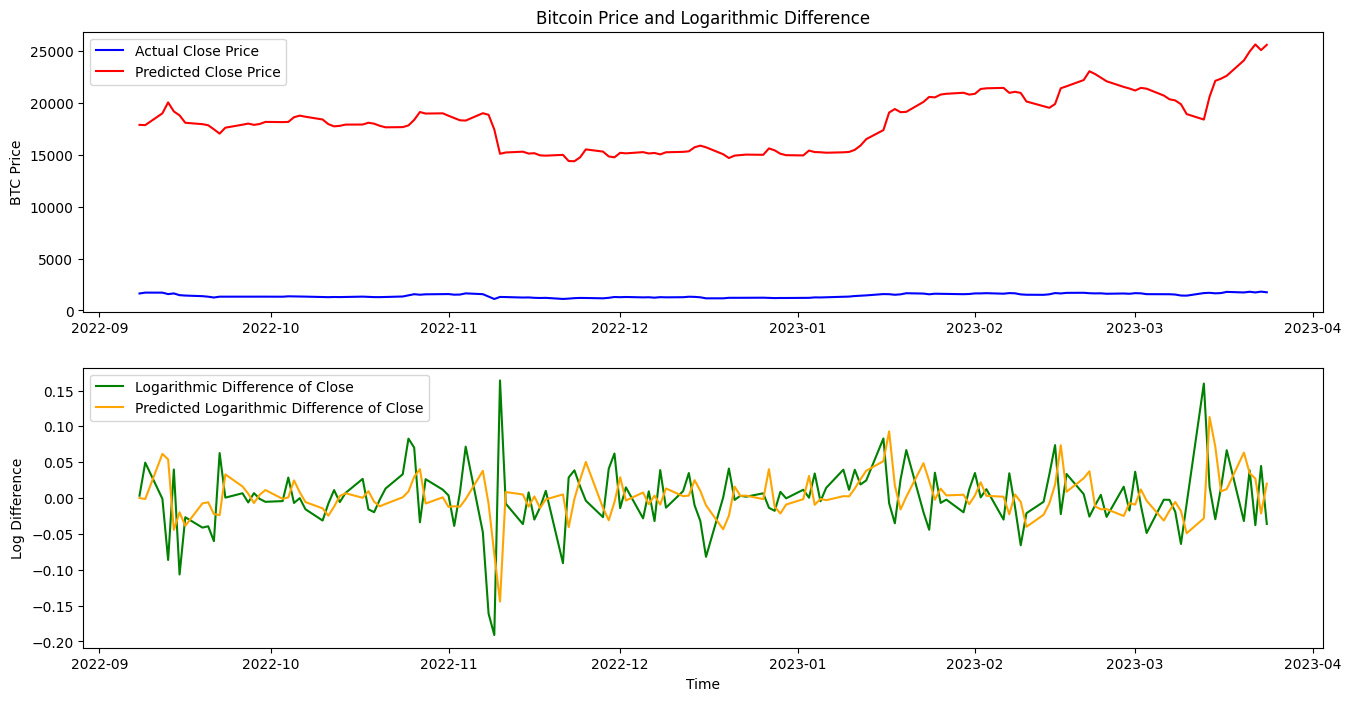

In [14]:
# Existing plot for 'Close' prices
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)  # First subplot in a 2x1 grid
plt.plot(actual_prices_aligned, label='Actual Close Price', color='blue')
plt.plot(predictions, label='Predicted Close Price', color='red')
plt.title('Bitcoin Price and Logarithmic Difference')
plt.ylabel('BTC Price')
plt.legend()

# New plot for 'Log_Diff_Close'
plt.subplot(2, 1, 2)  # Second subplot in a 2x1 grid
plt.plot(log_diff_actual, label='Logarithmic Difference of Close', color='green')
plt.plot(log_diff_predicted, label='Predicted Logarithmic Difference of Close', color='orange')
plt.xlabel('Time')
plt.ylabel('Log Difference')
plt.legend()

plt.show()